# 03 Predictive Analysis
### Author: Hugo Salas; Dataset: TOEFL11

asdsadsad
## 1. Import modules and data
#### 1a) Relevant modules and globals

In [39]:
# Modules
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import sys
import os
from os.path import exists
from scipy.special import softmax

from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import f1_score, accuracy_score, log_loss

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Path names
PATH_DATA = '../data/text/'
PATH_RESP = f'{PATH_DATA}/responses/'
PATH_MODELS = f'{PATH_RESP}/models/'
PATH_UTILS = f'/utils/'

# File names
RESP_JSON_OR = 'toefl11_resp_or.json'
TOEFL11_DF = "toefl11_DF.pkl"
TFIDF_15K = "toefl11_tfidf_15k.pkl"
TFIDF_15K_GR = "toefl11_tfidf_15k_3ngr.pkl"
TFIDF_1K = "toefl11_tfidf_1k.pkl"
TFIDF_1K_GR = "toefl11_tfidf_1k_3ngr.pkl"

# Color palette
PAL = "rocket"
COLORS = ['#B53158', '#E29072', "#59274E"]

# adding Folder_2 to the system path
sys.path.insert(0, f'{os.getcwd()}{PATH_UTILS}')

#### 1b) Import data

In [2]:
# Data frame with important features
toefl11_df = pd.read_pickle(PATH_RESP + TOEFL11_DF)
txt_file_lst = toefl11_df['Filename'].values

toefl11_df.head()

,Filename,Prompt,Language,Score Level,Essay length,Unique tokens,Mispelled words,ttr,rttr,cttr,...,rttr_quint_0_y,rttr_quint_1_y,rttr_quint_2_y,rttr_quint_3_y,rttr_quint_4_y,rttr_quint_0,rttr_quint_1,rttr_quint_2,rttr_quint_3,rttr_quint_4
0,88.txt,P6,KOR,high,416,163,0,0.391827,7.991733,5.651008,...,0,1,0,0,0,0,1,0,0,0
1,278.txt,P6,DEU,medium,339,129,3,0.380531,7.006318,4.954215,...,1,0,0,0,0,1,0,0,0,0
2,348.txt,P1,TUR,high,396,195,5,0.492424,9.799119,6.929023,...,0,0,0,0,1,0,0,0,0,1
3,666.txt,P2,ZHO,medium,402,166,2,0.412935,8.279327,5.854369,...,0,0,1,0,0,0,0,1,0,0
4,733.txt,P6,TEL,medium,362,149,8,0.411602,7.831266,5.537541,...,0,1,0,0,0,0,1,0,0,0


In [3]:
#TF-IDF dataframes
tfidf = {}

for tfidf_df in [TFIDF_15K, TFIDF_15K_GR, TFIDF_1K, TFIDF_1K_GR]:
    tfidf[tfidf_df] = pd.read_pickle(PATH_RESP + tfidf_df)

In [4]:
# Essays
toefl11_responses_dict = json.load(open(f'{PATH_RESP}/toefl11_resp_tok.json'))

## 2. Benchmark models
#### 2a) Logistic regression

log_models = {}
log_reg = LogisticRegressionCV(cv=5, random_state=0, penalty='l2', multi_class='multinomial', solver = 'newton-cg', max_iter = 300)

#For all of the different dataframes that we have available, let's run one regression and save it. 
for tfidf_df in [TFIDF_15K, TFIDF_15K_GR, TFIDF_1K, TFIDF_1K_GR]:
    scaler = preprocessing.StandardScaler().fit(tfidf[TFIDF_15K])
    X_scaled = scaler.transform(tfidf[TFIDF_15K])

    X_train, X_test, y_train, y_test = train_test_split(X_scaled, 
                                                        toefl11_df['Score Level'].astype("category"), 
                                                        test_size=0.30, 
                                                        random_state=0)

    log_models[tfidf_df] = log_reg.fit(X_train, y_train)
    pickle.dump(log_models[tfidf_df], open(f'{PATH_MODELS}/{tfidf_df[:-4]}.sav', 'wb'))


FileNotFoundError: [Errno 2] No such file or directory: '../data/text//responses//models//.sav'

In [ ]:
for tfidf_df in [TFIDF_15K, TFIDF_15K_GR, TFIDF_1K, TFIDF_1K_GR]: 
    log_model = pickle.load(open(f'{PATH_MODELS}/{tfidf_df[:-4]}.sav', 'rb'))
    scaler = preprocessing.StandardScaler().fit(tfidf[tfidf_df])
    X_scaled = scaler.transform(tfidf[tfidf_df])
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, 
                                                        toefl11_df['Score Level'].astype("category"), 
                                                        test_size=0.30, 
                                                        random_state=0)
    print(accuracy_score(y_test, log_model.predict(X_test)))

In [62]:
best_accr_dict = {}
best_loss_dict = {}

## 3. Closer to the state of the art
#### 3a) LSTM: Long Short Term Memory
i. Set our parameters 

In [6]:
from cleaning_NLP import clean_text, tokenize, run_lstm, tokenize_n_split

# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 300
# Test set size
TEST_SIZE = 0.2
# Random seed
RANDOM_STATE = 5212022
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000

In [7]:
# Create a list of all examples: one without stopwords
essay_lst_nostop = [clean_text(toefl11_responses_dict[txt]).replace('\d+', '') for txt in txt_file_lst]
essay_lst = [clean_text(toefl11_responses_dict[txt], False).replace('\d+', '') for txt in txt_file_lst]

In [8]:
def create_param_dict(units_lst = [50, 100], embedding_dim_lst = [100], 
                      dropout_lst = [0.60, 0.5, 0.4], rec_dropout_lst = [0.60, 0.5, 0.4],
                      essays_lst_lst = [essay_lst, essay_lst_nostop]):
#Creates a list with all of the parameters we want to tune

    param_dict = {}

    for units in units_lst:
        for embedding in embedding_dim_lst:
            for dropout in dropout_lst:
                for rec_dropout in rec_dropout_lst:
                    for lst in essays_lst_lst:
                        dict = {}
                        dict['units'] = units
                        dict['embedding_dim'] = embedding
                        dict['dropout'] = dropout
                        dict['rec_dropout'] = rec_dropout
                        dict['lst'] = lst
                        param_dict[len(param_dict)] = dict
    
    return param_dict

In [9]:
param_dict = create_param_dict()

iia. Run models

In [10]:
def loop_over_lstms(param_dict):
    Y = toefl11_df[['score_high', 'score_low', 'score_medium']].values
    history_lst = []
    accr_test_lst = []
    for key in param_dict.keys():
        print([(subkey, param_dict[key][subkey]) for subkey in param_dict[key].keys() if subkey!='lst'] + 
            [('len 1st lst', len(param_dict[key]['lst'][0]))])
        X_train, X_test, Y_train, Y_test = tokenize_n_split(param_dict[key]['lst'], Y, MAX_NB_WORDS, 
                                                            MAX_SEQUENCE_LENGTH, test_size = TEST_SIZE, 
                                                            random_state = RANDOM_STATE)
        model, history = run_lstm(X_train, Y_train, MAX_NB_WORDS, param_dict[key]['embedding_dim'], 
                                dropout = param_dict[key]['dropout'], rec_dropout = param_dict[key]['rec_dropout'],
                                epochs = 5, batch_size = 64, lstm_units = param_dict[key]['units'])
        accr_test = model.evaluate(X_test,Y_test)
        print('       Test accuracy:', accr_test[1])
        
        history_lst.append(history)   
        accr_test_lst.append(accr_test) 
        model.save(f'{PATH_MODELS}/lstm_{key}')
        print('')

    return history_lst, accr_test_lst

In [ ]:
history_lst, accr_test_lst = loop_over_lstms(param_dict)

iib. Load models and calculate accuracy (only run if didn't run iia)

In [12]:
# If we don't need to train our data, we can use the models we've already trained
accr_test_lst = []
for key in param_dict.keys():
    if exists(f'{PATH_MODELS}/lstm_{key}'):
        X_train, X_test, Y_train, Y_test = tokenize_n_split(param_dict[key]['lst'], Y, MAX_NB_WORDS, 
                                                            MAX_SEQUENCE_LENGTH, test_size = TEST_SIZE, 
                                                            random_state = RANDOM_STATE)
        model = tf.keras.models.load_model(f'{PATH_MODELS}/lstm_{key}')
        accr_test = model.evaluate(X_test,Y_test)
        print('       Test accuracy:', accr_test[1])
        accr_test_lst.append(accr_test) 
        print('')

iii. Get model with highest accuracy

In [13]:
#Get it all in a DF
def build_accr_df():
    accr_lstm_df = pd.DataFrame(columns=['units', 'embedding_dim', 'dropout', 'rec_dropout', 'No Stopwords', 'Accuracy', 'Loss', 'max_seq'])

    for col in accr_lstm_df.columns[:-4]:
        accr_lstm_df[col] = [param_dict[key][col] for key in param_dict.keys()][:len(accr_test_lst)]
    accr_lstm_df['No Stopwords'] = [len(param_dict[key]['lst'][0]) == 1196 for key in param_dict.keys()][:len(accr_test_lst)]
    accr_lstm_df['Loss'] = [i[0] for i in accr_test_lst]
    accr_lstm_df['Accuracy'] = [i[1] for i in accr_test_lst]
    accr_lstm_df['max_seq'] = MAX_SEQUENCE_LENGTH

    return accr_lstm_df

In [ ]:
accr_lstm_df.head()

In [125]:
temp_df = accr_lstm_df[accr_lstm_df['units']!=150]

In [129]:
# Grab best models according to accuracy and loss
best_accr_dict['lstm1'] = temp_df[temp_df['Accuracy']==temp_df['Accuracy'].max()]
best_loss_dict['lstm1'] = temp_df[temp_df['Loss']==temp_df['Loss'].min()]

iv. Graph the loss and accuracy across models

- Should we use stopwords?

In [97]:
temp_df = accr_lstm_df[accr_lstm_df['units']!=150]
sns.set_style(style="whitegrid")

def bplot(xvar, yvar, hue, leg_title, leg_pos, lposx = 0.95, lposy = 0.05):
    ax = sns.boxplot(x=xvar, y=yvar, hue=hue, data=temp_df, palette=PAL)
    ax.set_ylabel(yvar)
    plt.legend(bbox_to_anchor=(lposx, lposy), loc=leg_pos, borderaxespad=0, title=leg_title)
    plt.show()

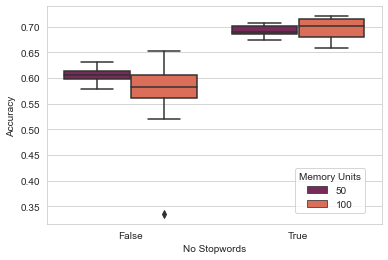

In [98]:
bplot('No Stopwords', 'Accuracy', 'units', 'Memory Units', 'lower right')

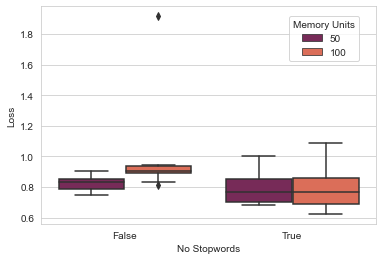

In [99]:
bplot('No Stopwords', 'Loss', 'units', 'Memory Units', 'lower right', lposy=0.75)

- Dropout rate?

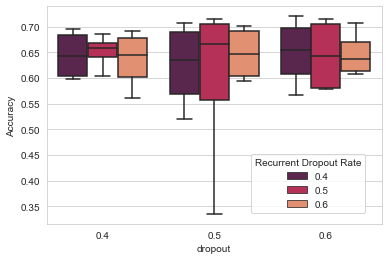

In [100]:
bplot('dropout', 'Accuracy', 'rec_dropout', 'Recurrent Dropout Rate', 'lower right')

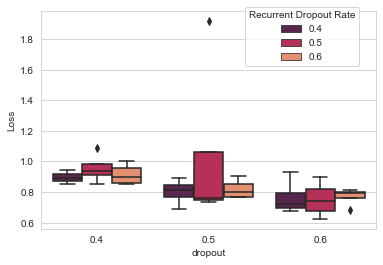

In [101]:
bplot('dropout', 'Loss', 'rec_dropout', 'Recurrent Dropout Rate', 'lower right', lposy= 0.75)

v. Run additional models with the information we now have (removing stopwords and increasing the max sequence)

In [159]:
MAX_SEQUENCE_LENGTH = 600
param_dict = create_param_dict(units_lst = [100], embedding_dim_lst = [100], 
                               dropout_lst = [0.8, 0.7, 0.60], rec_dropout_lst = [0.4, 0.5, 0.6],
                               essays_lst_lst=[essay_lst_nostop])

In [ ]:
history_lst, accr_test_lst = loop_over_lstms(param_dict)
#accr_test_lst = [[0.6101, 0.7169], [0.8604 ,0.5430], [0.9743 ,0.5545], [0.6056 ,0.7223], [0.7729 ,0.6562], [0.6756 ,0.7000], [0.6790 ,0.7054], [0.6851 ,0.7037],[0.6906 ,0.7277]]

In [168]:
temp_df = build_accr_df().append(temp_df)
temp_df.head()

,units,embedding_dim,dropout,rec_dropout,No Stopwords,Accuracy,Loss,max_seq
0,100,100,0.8,0.4,True,0.7169,0.6101,600
1,100,100,0.8,0.5,True,0.5430,0.8604,600
2,100,100,0.8,0.6,True,0.5545,0.9743,600
3,100,100,0.7,0.4,True,0.7223,0.6056,600
4,100,100,0.7,0.5,True,0.6562,0.7729,600


vi. Graph most recent results

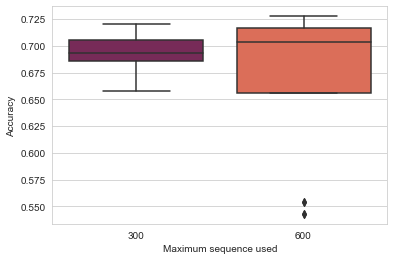

In [176]:
ax = sns.boxplot(x='max_seq', y='Accuracy', data=temp_df[temp_df['No Stopwords']==True], palette=PAL)
ax.set_xlabel('Maximum sequence used')
plt.show()

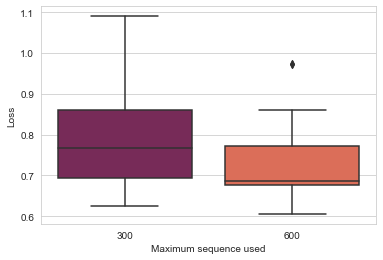

In [188]:
ax = sns.boxplot(x='max_seq', y='Loss', data=temp_df[temp_df['No Stopwords']==True], palette=PAL)
ax.set_xlabel('Maximum sequence used')
plt.show()

In [185]:
# Grab best models according to accuracy and loss
best_accr_dict['lstm2'] = temp_df[temp_df['Accuracy']==temp_df['Accuracy'].max()][:1]
best_loss_dict['lstm2'] = temp_df[temp_df['Loss']==temp_df['Loss'].min()][:1]

#### 3b) BERT: Bidirectional Encoder Representations from Transformers 

In [230]:
import torch
from tqdm.notebook import tqdm

from transformers import BertForSequenceClassification
from transformers import BertTokenizer
from transformers import AdamW, get_linear_schedule_with_warmup

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

from sklearn.model_selection import train_test_split

In [208]:
MAX_SEQUENCE_LENGTH = 300

Y = toefl11_df[['score_high', 'score_low', 'score_medium']].values

X_train, X_val, y_train, y_val = train_test_split(essay_lst_nostop, 
                                                  Y, 
                                                  test_size=TEST_SIZE, 
                                                  random_state=RANDOM_STATE)


In [209]:
print('Training data:', y_train.shape)
print('Test/Validation data:', y_val.shape)

Training data: (9680, 3)
Test/Validation data: (2420, 3)


In [296]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', 
                                          do_lower_case=True)
                                          
encoded_data_train = tokenizer.batch_encode_plus(
    X_train, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=MAX_SEQUENCE_LENGTH, 
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    X_val, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=MAX_SEQUENCE_LENGTH, 
    return_tensors='pt'
)

input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(y_train).float()

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(y_val).float()

dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
c:\Users\hugo3\Anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:2285: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [228]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=Y.shape[1],
                                                      output_attentions=False,
                                                      output_hidden_states=False)

Downloading: 100%|██████████| 420M/420M [07:39<00:00, 958kB/s]    
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSeque

In [297]:
batch_size = 3

dataloader_train = DataLoader(dataset_train, 
                              sampler=RandomSampler(dataset_train), 
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val, 
                                   sampler=SequentialSampler(dataset_val), 
                                   batch_size=batch_size)

optimizer = AdamW(model.parameters(),
                  lr=1e-5, 
                  eps=1e-8)

epochs = 5

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)

c:\Users\hugo3\Anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [298]:
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

In [299]:
import random

seed_val = RANDOM_STATE
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [300]:
def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }
        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals

In [302]:
for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       
        outputs = model(**inputs)

        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    torch.save(model.state_dict(), f'data_volume/finetuned_BERT_epoch_{epoch}.model')
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/3227 [00:00<?, ?it/s]

ii. Load predictions if not already loaded

In [53]:
true_vals = pickle.load(open(f'{PATH_MODELS}/truevals_BERT.pkl', 'rb'))
predictions = pickle.load(open(f'{PATH_MODELS}/pred_BERT.pkl', 'rb'))

predictions_flat = np.argmax(predictions, axis=1).flatten()
true_vals_flat = true_vals[:,0]*0 + true_vals[:,1]*1 + true_vals[:,2]*2

pred_softmax = softmax(predictions, axis = 1)

In [68]:
best_accr_dict['BERT'] = {'Accuracy': accuracy_score(true_vals_flat, predictions_flat)}
best_accr_dict

{'lstm1': {'Accuracy': 0.720661},
 'lstm2': {'Accuracy': 0.7277},
 'BERT': {'Accuracy': 0.7264462809917356}}

In [67]:
best_accr_dict = {'lstm1': {'Accuracy': 0.720661}, 'lstm2': {'Accuracy': 0.7277}}
best_loss_dict = {'lstm1': {'Loss': 0.677138}, 'lstm2': {'Loss': 0.6906}}